In [6]:
import torch
from pca import pca
from lda import lda
from load import load_and_split_data
from plot import plot_eigenfaces, plot_2d_data

import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# 1. 加载数据
train_data, test_data, train_label, test_label = load_and_split_data()

if torch.cuda.is_available():
  train_data = train_data.cuda()
  test_data = test_data.cuda()

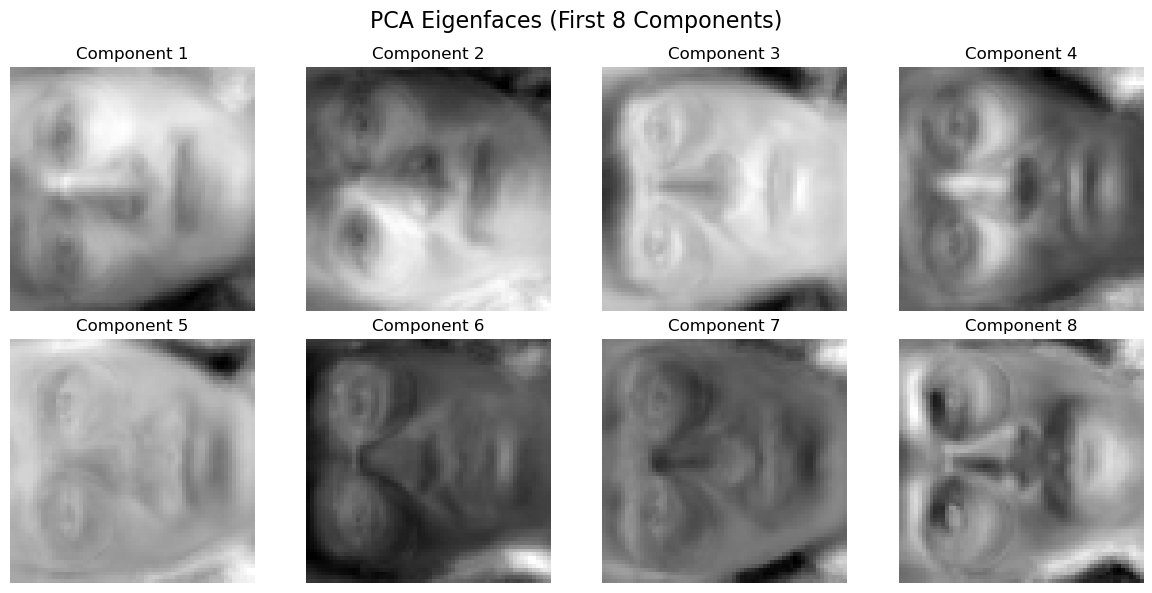

In [6]:
# 2. 学习PCA投影矩阵
lda_components, pca_ratio = pca(train_data, n_components=8)

# 显示PCA特征脸
plot_eigenfaces(lda_components, "PCA Eigenfaces (First 8 Components)")

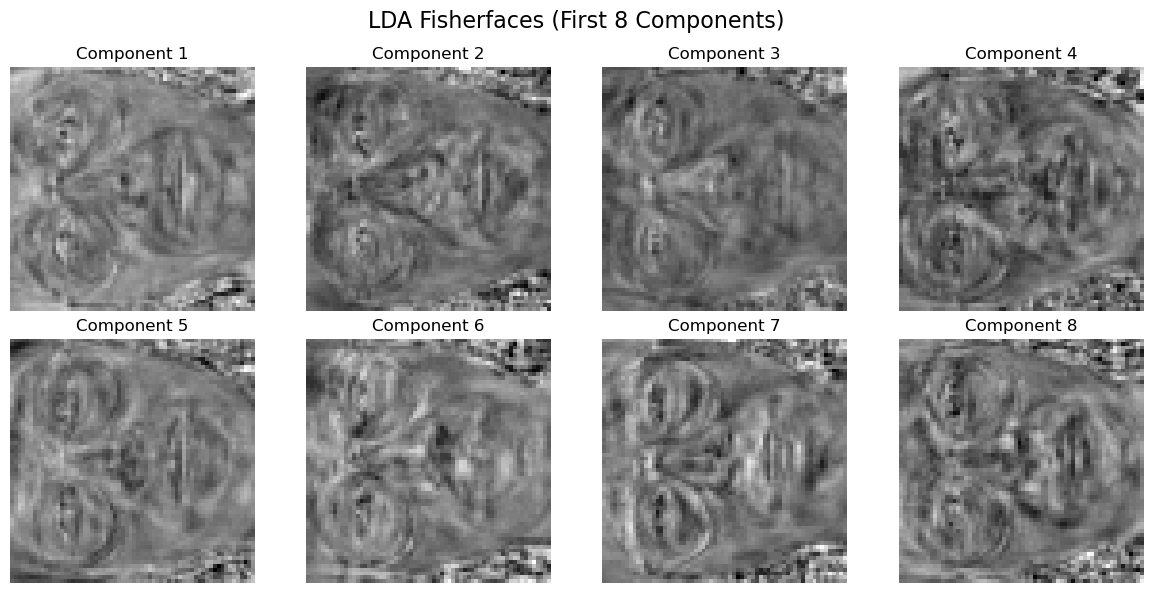

In [7]:
# 3. 学习LDA投影矩阵
lda_components, lda_ratio = lda(train_data, train_label, n_components=8)

# 显示LDA Fisher脸
plot_eigenfaces(lda_components, "LDA Fisherfaces (First 8 Components)")

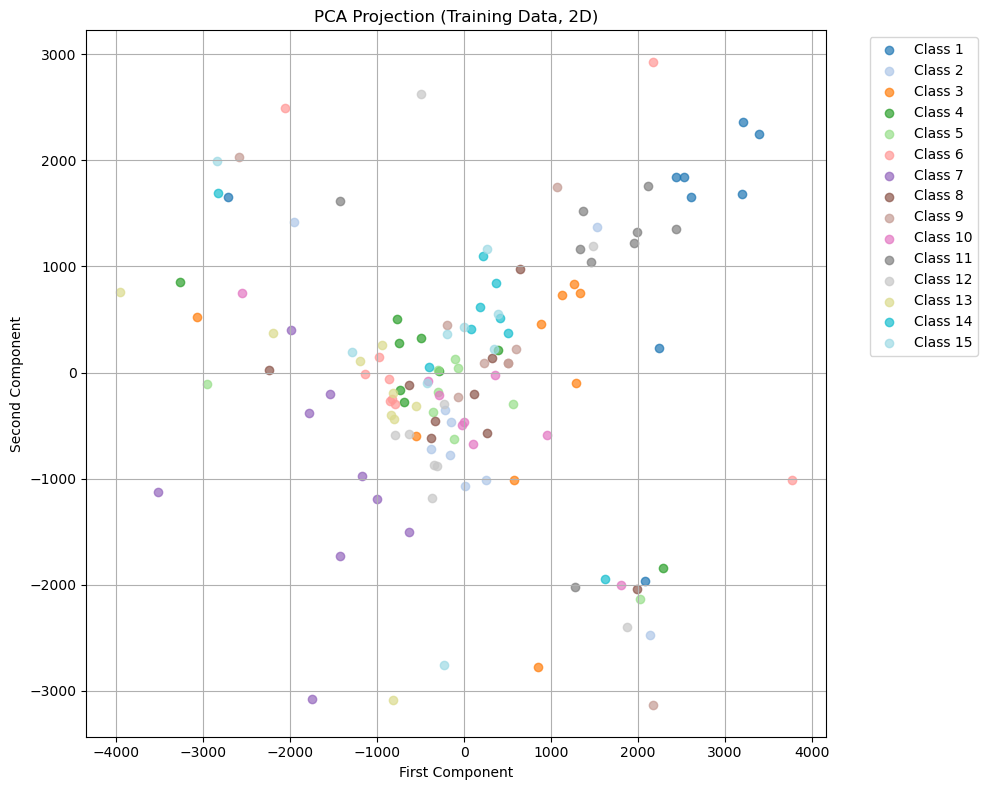

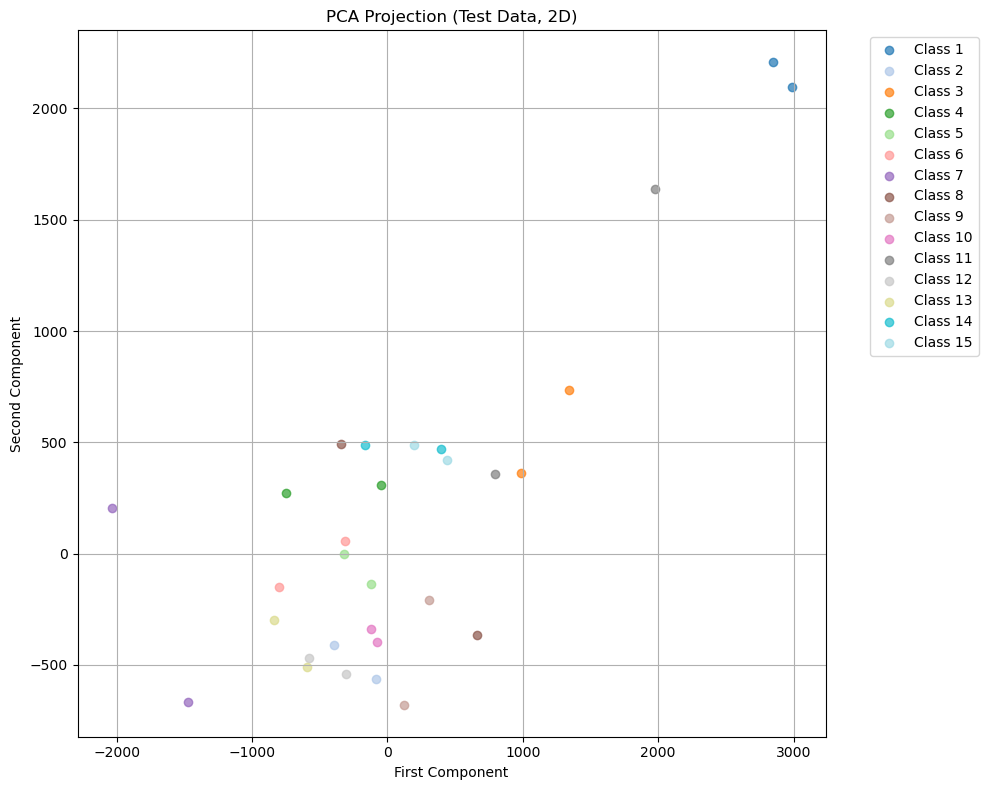

In [8]:
# PCA降维
pca_components_2d, _ = pca(train_data, n_components=2)

train_pca_2d = (train_data - torch.mean(train_data, axis=0)) @ pca_components_2d

plot_2d_data(train_pca_2d, train_label, "PCA Projection (Training Data, 2D)")

test_pca_2d = (test_data - torch.mean(train_data, axis=0)) @ pca_components_2d

plot_2d_data(test_pca_2d, test_label, "PCA Projection (Test Data, 2D)")

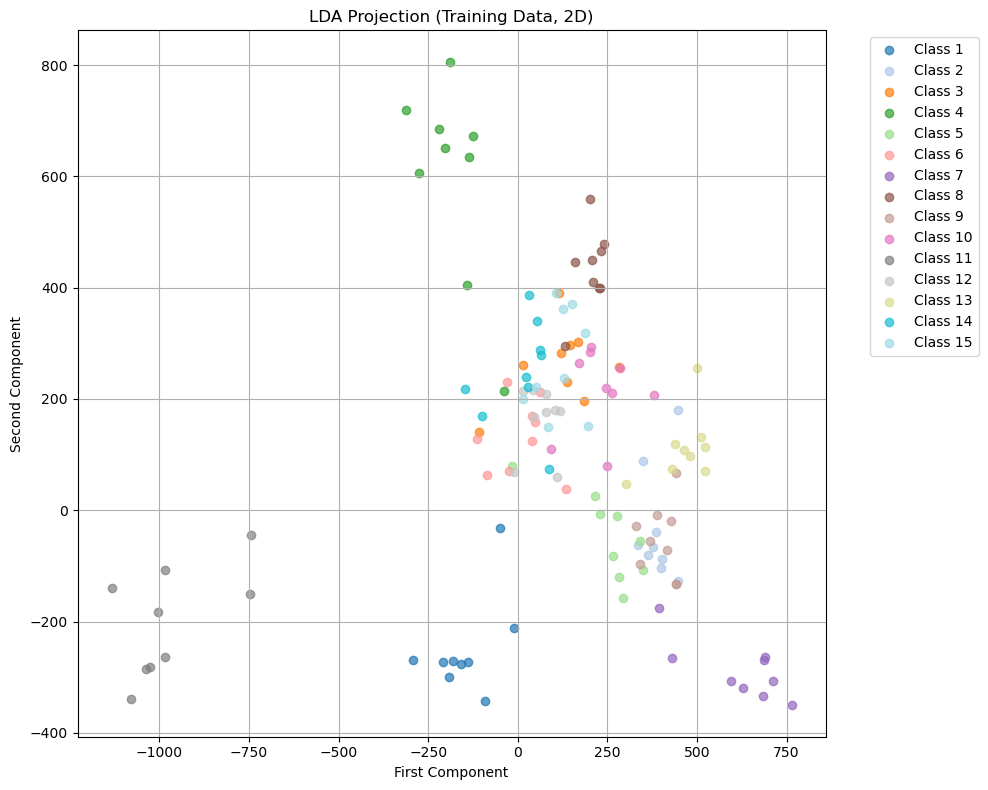

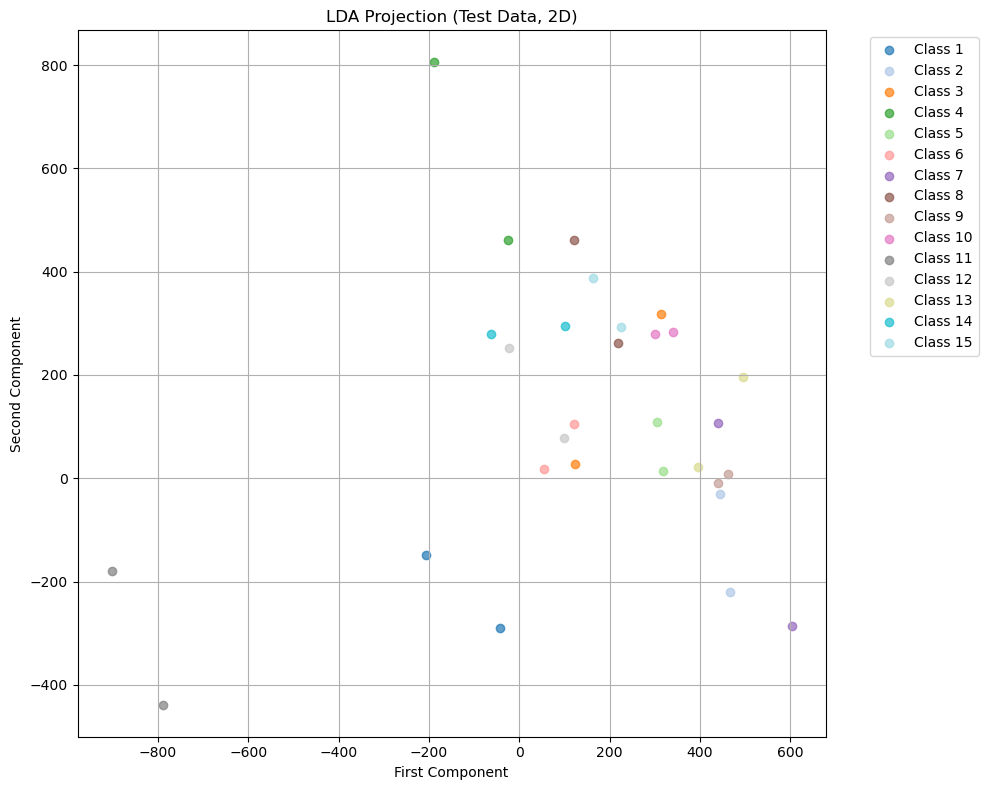

In [9]:
# LDA降维
lda_components_2d, _ = lda(train_data, train_label, n_components=2)

train_lda_2d = train_data @ lda_components_2d

plot_2d_data(train_lda_2d, train_label, "LDA Projection (Training Data, 2D)")

test_lda_2d = test_data @ lda_components_2d

plot_2d_data(test_lda_2d, test_label, "LDA Projection (Test Data, 2D)")

In [ ]:
from plot import plot_accuracy_reduced_dim
from knn import KNN

# 创建KNN分类器
knn = KNN(k=3)

def pca_reduce_dim_and_evaluate(dim):
  pca_components, _ = pca(train_data, n_components=dim)
  train_pca = (train_data - torch.mean(train_data, axis=0)) @ pca_components
  test_pca = (test_data - torch.mean(train_data, axis=0)) @ pca_components
  knn.fit(train_pca, train_label)
  accuracy = knn.evaluate(test_pca, test_label)
  print(f"PCA reduced to {dim}d, KNN Accuracy: {accuracy:.2f}")
  return accuracy

def lda_reduce_dim_and_evaluate(dim):
  lda_components, _ = lda(train_data, train_label, n_components=dim)
  train_pca = train_data @ lda_components
  test_pca = test_data @ lda_components
  knn.fit(train_pca, train_label)
  accuracy = knn.evaluate(test_pca, test_label)
  print(f"LDA reduced to {dim}d, KNN Accuracy: {accuracy:.2f}")
  return accuracy

reduced_dims = range(1, 9)
pca_accuracies = []
lda_accuracies = []

for dim in reduced_dims:
  pca_accuracies.append(pca_reduce_dim_and_evaluate(dim))
  lda_accuracies.append(lda_reduce_dim_and_evaluate(dim))

plot_accuracy_reduced_dim(
  reduced_dims,
  [pca_accuracies, lda_accuracies],
  ["PCA reduced", "LDA reduced"],
)



PCA reduced to 1d, KNN Accuracy: 0.33
LDA reduced to 1d, KNN Accuracy: 0.37
PCA reduced to 2d, KNN Accuracy: 0.43
LDA reduced to 2d, KNN Accuracy: 0.47
PCA reduced to 3d, KNN Accuracy: 0.57
